Construct The first 100 Harmonics for a Single HCP Subject

In [9]:
#import modules with core Connectome Harmonic functionality
import utility_functions
import input_output
import matrix_methods
import decomp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load in endpoint coordinates from .vtk
endpoint_coordinates = input_output.read_streamline_endpoints("/home/neuro/data/5M_SIFT_endpoints.vtk")

In [3]:
#load in surface coordinate, connectivity info
surface_coordinates, surface_indices = input_output.read_vtk_surface_both_hem("/home/neuro/data/L.white.LR.surf.vtk","/home/neuro/data/R.white.LR.surf.vtk")

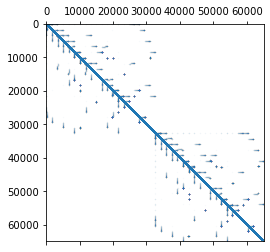

In [4]:
#construct surface matrix from surface coordinates and surface indices,visualize sparsity structure
surface_matrix = matrix_methods.construct_surface_matrix(surface_coordinates, surface_indices)
plt.spy(surface_matrix, markersize=0.01)

In [5]:
#construct interhemispheric connections, structural connectivity matrix
inter_hemi_connections = matrix_methods.construct_inter_hemi_matrix(surface_coordinates)
structural_conn = matrix_methods.construct_structural_connectivity_matrix(surface_coordinates, endpoint_coordinates)


neighbors time= 0.1673269271850586
neighbors time= 0.13745713233947754
neighbors time= 33.29572510719299
neighbors time= 16.41233205795288
neighbors time= 14.901470422744751
3508611
3507592


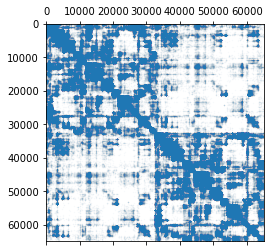

In [6]:
#visualize sparsity structure
plt.spy(structural_conn, markersize=0.01)

In [7]:
#construct full adjacency matrix, find first 100 harmonics eigenvecs, eigenvals
adjacency = surface_matrix + inter_hemi_connections + structural_conn
vals, vecs = decomp.lapDecomp(adjacency, 100)

decomposition time= 59.81046676635742 seconds, which is 0.9968411127726237 minutes


In [11]:
#save eigenvals, eigenvecs
np.save("/home/neuro/output/evalsevecs.npy", [vals,vecs])
input_output.save_eigenvector("/home/neuro/output/evecs.vtk", surface_coordinates, surface_indices, vecs)

In [ ]:
#visualize eigenvectors on surface with paraview 
import vtk

filename = "/home/neuro/output/evecs.vtk"

imageData = vtk.vtkImageData()
imageData.SetDimensions(3, 4, 5)
if vtk.VTK_MAJOR_VERSION <= 5:
    imageData.SetNumberOfScalarComponents(1)
    imageData.SetScalarTypeToDouble()
else:
    imageData.AllocateScalars(vtk.VTK_DOUBLE, 1)

dims = imageData.GetDimensions()

# Fill every entry of the image data with "2.0"
for z in range(dims[2]):
    for y in range(dims[1]):
        for x in range(dims[0]):
            imageData.SetScalarComponentFromDouble(x, y, z, 0, 2.0)


writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName(filename)
if vtk.VTK_MAJOR_VERSION <= 5:
    writer.SetInputConnection(imageData.GetProducerPort())
else:
    writer.SetInputData(imageData)
writer.Write()

# Read the file (to test that it was written correctly)
reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(filename)
reader.Update()

# Convert the image to a polydata
imageDataGeometryFilter = vtk.vtkImageDataGeometryFilter()
imageDataGeometryFilter.SetInputConnection(reader.GetOutputPort())
imageDataGeometryFilter.Update()

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(imageDataGeometryFilter.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetPointSize(3)

# Setup rendering
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1,1,1)
renderer.ResetCamera()

renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

renderWindowInteractor = vtk.vtkRenderWindowInteractor()

renderWindowInteractor.SetRenderWindow(renderWindow)
renderWindowInteractor.Initialize()
renderWindowInteractor.Start()